<a href="https://colab.research.google.com/github/atamadon/heartsound/blob/main/Single_Image_GAN(128x128).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adapted from DCGAN to generate face images

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/04/29<br>
**Last modified:** 2021/01/01<br>
**Description:** A simple DCGAN trained using `fit()` by overriding `train_step` on CelebA images.

Keras: https://keras.io/examples/generative/dcgan_overriding_train_step/

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

## Prepare data

We'll use face images from the CelebA dataset, resized to 64x64.

In [ ]:
base_dir = "/content/drive/MyDrive/HeartSound/Data/spectrograms"

train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')

# Directory with training normal/abnormal spectrograms
train_AS  = os.path.join(train_dir, 'AS')
train_MR  = os.path.join(train_dir, 'MR')
train_MS  = os.path.join(train_dir, 'MS')
train_MVP = os.path.join(train_dir, 'MVP')
train_N   = os.path.join(train_dir, 'N')



# Directory with test normal/abnormal spectrograms

test_AS  = os.path.join(test_dir, 'AS')
test_MR  = os.path.join(test_dir, 'MR')
test_MS  = os.path.join(test_dir, 'MS')
test_MVP = os.path.join(test_dir, 'MVP')
test_N   = os.path.join(test_dir, 'N')

Dataset from a single heart sound class (Normal)

In [ ]:
#Set classifiction as a string of the directory name of the class of images to generate (N, AS, MR, MS, MVP)
classification = "N"

dataset = keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/HeartSound/Data/spectrograms/train/"+classification, label_mode=None, image_size=(128, 128), batch_size=32
)
#To-do: Create with 150x150
dataset = dataset.map(lambda x: x / 255.0)


Found 160 files belonging to 1 classes.


Let's display a sample image:

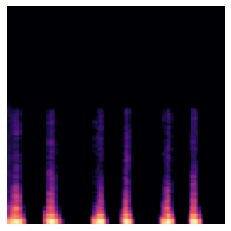

In [ ]:

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
#discriminator.summary()

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(16 * 16 * 128),
        layers.Reshape((16, 16, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
#generator.summary()

## Override `train_step`

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## Create a callback that periodically saves generated images

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/content/images/"+classification+"generated_img_%03d_%d.png" % (epoch, i))


## Train the end-to-end model

In [ ]:
#Set epochs to +500 for best results
epochs = 1000

!rm -rfv /content/images
!mkdir -v /content/images

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

removed '/content/images/Ngenerated_img_005_8.png'
removed '/content/images/Ngenerated_img_041_8.png'
removed '/content/images/Ngenerated_img_015_5.png'
removed '/content/images/Ngenerated_img_017_8.png'
removed '/content/images/Ngenerated_img_009_7.png'
removed '/content/images/Ngenerated_img_021_3.png'
removed '/content/images/Ngenerated_img_002_8.png'
removed '/content/images/Ngenerated_img_009_0.png'
removed '/content/images/Ngenerated_img_038_7.png'
removed '/content/images/Ngenerated_img_009_8.png'
removed '/content/images/Ngenerated_img_009_4.png'
removed '/content/images/Ngenerated_img_023_6.png'
removed '/content/images/Ngenerated_img_013_8.png'
removed '/content/images/Ngenerated_img_028_8.png'
removed '/content/images/Ngenerated_img_036_5.png'
removed '/content/images/Ngenerated_img_047_7.png'
removed '/content/images/Ngenerated_img_041_0.png'
removed '/content/images/Ngenerated_img_024_8.png'
removed '/content/images/Ngenerated_img_025_9.png'
removed '/content/images/Ngener

## Download Generated Images

In [ ]:
import shutil
from google.colab import files
shutil.make_archive("generatedImages"+classification, 'zip', "/content/images")
files.download("generatedImages"+classification+".zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>